# Stacking Method

### *Kaggle Ensembling Guide*

Model ensembling is a very powerful technique to increase accuracy on a variety of ML tasks. The ensembling approaches for Kaggle Competitions are shared: https://mlwave.com/kaggle-ensembling-guide/

### *ashrae-ensembling-1*

submittion_01: https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

submittion_02: https://www.kaggle.com/rohanrao/ashrae-half-and-half

submittion_03: https://www.kaggle.com/isaienkov/keras-nn-with-embeddings-for-cat-features-1-15

submittion_04: https://www.kaggle.com/kimtaegwan/what-s-your-cv-method


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir('/kaggle/input/ashrae-ensembling-1'))

# Any results you write to the current directory are saved as output.

['submission_02.csv', 'submission_01.csv', 'submission_04.csv', 'submission_03.csv']


### step1: Stat Stack

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

ashrae-energy-prediction
ashrae-ensembling-1



### step2

In [3]:
sub_path = "../input/ashrae-ensembling-1"
all_files = os.listdir(sub_path)
all_files

['submission_02.csv',
 'submission_01.csv',
 'submission_04.csv',
 'submission_03.csv']

### step3

In [4]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

### step4: check correlation

In [5]:
concat_sub.iloc[:,1:].corr()

,mol0,mol1,mol2,mol3
mol0,1.000000,0.710517,0.948020,0.082518
mol1,0.710517,1.000000,0.620499,0.152048
mol2,0.948020,0.620499,1.000000,0.060511
mol3,0.082518,0.152048,0.060511,1.000000


### step5

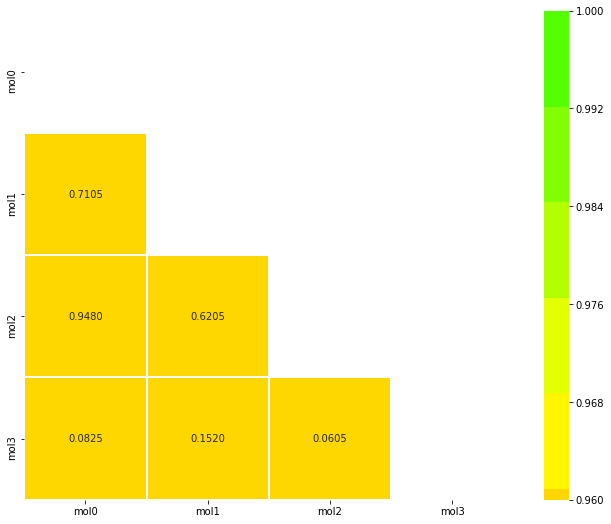

In [6]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

### step6: get the data fields ready for stacking

In [7]:
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

### step7

In [8]:
concat_sub.describe()

,row_id,mol0,mol1,mol2,mol3,m_max,m_min,m_median
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,5.005925e+02,3.653579e+02,6.737280e+02,2.894877e+02,7.238856e+02,2.571780e+02,4.240513e+02
std,1.203706e+07,9.424756e+03,2.257046e+03,2.121556e+04,7.458033e+03,2.249639e+04,1.245054e+03,5.527539e+03
min,0.000000e+00,0.000000e+00,-5.267000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-5.267000e-01,0.000000e+00
25%,1.042440e+07,2.174547e+01,2.046670e+01,2.150517e+01,2.429385e+01,2.674910e+01,1.819570e+01,2.210655e+01
50%,2.084880e+07,7.495337e+01,7.439535e+01,7.563206e+01,7.575477e+01,8.857106e+01,6.383088e+01,7.604559e+01
75%,3.127320e+07,2.250247e+02,2.315152e+02,2.324566e+02,2.134130e+02,2.710787e+02,1.865067e+02,2.272590e+02
max,4.169760e+07,1.032290e+06,3.482294e+05,3.334068e+06,4.725081e+07,4.725081e+07,6.854116e+04,5.969210e+05


### step8

In [9]:
cutoff_lo = 0.8
cutoff_hi = 0.2

### step9

In [10]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

### step10

In [11]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

### step11: Mean Stacking

In [12]:
concat_sub['meter_reading'] = concat_sub['m_mean']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

### step12: Median Stacking

In [13]:
concat_sub['meter_reading'] = concat_sub['m_median']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

### step13: Pushout + Median Stacking

In [14]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

### step14: MinMax + Mean Stacking

In [15]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

### step15: MinMax + Median Stacking

In [16]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

### step16: Averaging Ranks

In [17]:
concat_sub['meter_reading'] = concat_sub['mol0'].rank(method ='min') + concat_sub['mol1'].rank(method ='min') + concat_sub['mol2'].rank(method ='min') 
concat_sub['meter_reading'] = (concat_sub['meter_reading']-concat_sub['meter_reading'].min())/(concat_sub['meter_reading'].max() - concat_sub['meter_reading'].min())
concat_sub.describe()
concat_sub[['row_id', 'meter_reading']].to_csv('stack_rank.csv', index=False, float_format='%.8f')